# Fluctuations in pedestrian dynamics routing choices.
## Pedestrian tracking at the Glow 19 festival

### How to cite

- **Dataset**
```
A. Gabbana, F. Toschi, P. Ross, A. Haans, and A. Corbetta. (2022). 
Fluctuations in pedestrian dynamics routing choices. 
https://doi.org/10.5281/zenodo.7007358
```


- **Paper 1**
```
A. Gabbana, F. Toschi, P. Ross, A. Haans, and A. Corbetta. (2022). 
Fluctuations in pedestrian dynamics routing choices. 
PNAS Nexus. https://doi.org/10.1093/pnasnexus/pgac169
```


- **Paper 2**
```
Gabbana, A., Corbetta, A., & Toschi, F. (2022). 
Modeling Routing Choices in Unidirectional Pedestrian Flows. 
Collective Dynamics, 6, 1–9. https://doi.org/10.17815/CD.2021.135
```

In this notebook we provide a few examples of data analysis using the [dataset of 
trajectories](https://doi.org/10.5281/zenodo.7007358) recorder during the 
2019 [Glow festival](https://gloweindhoven.nl/) in the city of Eindhoven (The Netherlands)
by the [Crodflow group at Eindhoven University of Technology](https://crowdflow.phys.tue.nl)


The experimental setup, sketched in the figure below, was established on the perimeter of the
Philips Stadium, along the uni-directional route of the festival amid two consecutive festival exhibits. 
When approaching the setup, each pedestrian faced a binary choice: passing
an external pillar bearing the stadium grandstands either by its right or left side. Respectively, these
were a slightly shorter and approximately straight path, in the following referred to as path
A, and a curved path partially intersecting a bicycle lane (closed during the experiment),
named path B henceforth.

The experiment lasted the entire duration of Glow 2019, 
from November 9th until November 16th, 2019. 
The tracking was performed during the festival opening hours,
every day from 18:00 until 00:00.
Note that the data collected on the 14th of November has not been included, 
since on that day the experimental setup was modified in order to evaluate 
the impact of changing the lighting conditions on the crowd dynamic.

We acquired individual pedestrian trajectories at 30 Hz time resolution by means of
overhead depth images and the [HA-HOG localization method](https://doi.org/10.17815/CD.2020.30 ). 
We collected raw depth images of a walkable area of about $30 m^2$ via 8 Orbbec Persee sensors attached
underneath a pedestrian overpass, and arranged in a 4x2 grid (see dashed black line in the Figure below).

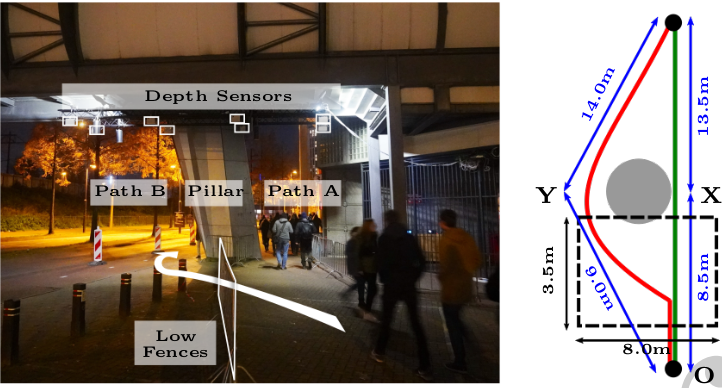

### 1. Import Libraries

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import pandas as pd
import numpy as np

### 2. Fetch the dataset

In [2]:
# Get the data, placing it in the same folder of this script
!wget https://zenodo.org/record/7007358/files/glow19_pnasnexus.csv

### 3. Import the data using pandas

In [3]:
df = pd.read_csv('glow19_pnasnexus.csv')

The dataset consists of 8 columns:

- **time** : timestamp (GTM+2)
- **tracked_object** : unique id identifying a pedestrian
- **x**, **y** : coordinates of the tracked object at given time. Unit measure: meters
- **x_sav**, **y_sav** : coordinates of the tracked object at given time, having applied a Savitzky-Golay filter to the entire trajectory. Unit measure: meters
- **vx_sav**, **vy_sav** : instantaneous velocity, calculated from the smoothed coordinates . Unit measure: meters/second


In [4]:
df.head()

,time,tracked_object,x,y,x_sav,y_sav,vx_sav,vy_sav
0,2019-11-09 18:00:48.264568,0,4.459598,7.964503,4.462628,7.987061,-0.444652,-0.274638
1,2019-11-09 18:00:48.298881,0,4.433442,7.964503,4.447337,7.978078,-0.496964,-0.248482
2,2019-11-09 18:00:48.331560,0,4.420364,7.964503,4.431028,7.969272,-0.549276,-0.235404
3,2019-11-09 18:00:48.365414,0,4.407286,7.990659,4.412364,7.963319,-0.588510,-0.196170
4,2019-11-09 18:00:48.396176,0,4.394208,7.964503,4.391131,7.957662,-0.614666,-0.130780


### 4. Plot of 1000 random trajectories

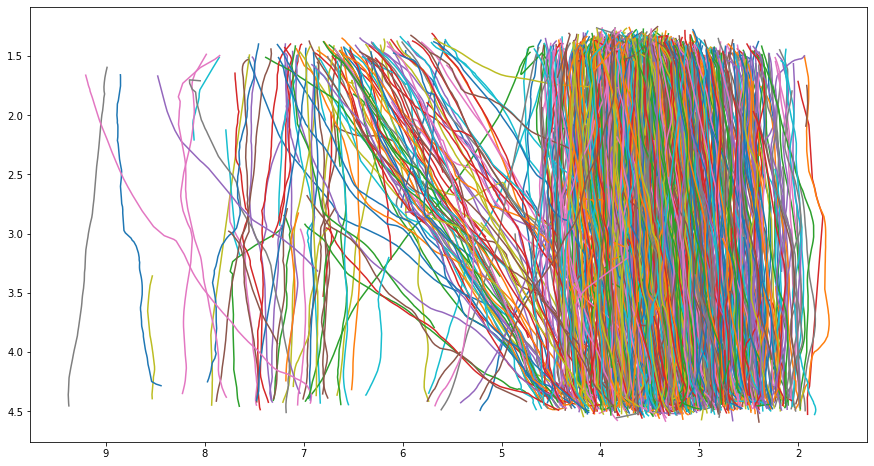

In [5]:
fig, ax = plt.subplots(figsize=(15,8))

num_tr = 1000
trLst = np.random.choice(np.arange(100_000), num_tr)

df[df['tracked_object'].isin(trLst)].groupby('tracked_object').apply(lambda elem : ax.plot(elem.y_sav, elem.x_sav))

ax.invert_xaxis()
ax.invert_yaxis()

plt.show()

### 5. Compute the local and global pedestrian count

In [6]:
# make sure the datatype for the time column is correct
df['time']= pd.to_datetime(df.time)

# compute final and initial x/y position and time for each trajectory
df['x_i'] = df.groupby('tracked_object').x_sav.transform('first')
df['x_f'] = df.groupby('tracked_object').x_sav.transform('last' )
df['y_i'] = df.groupby('tracked_object').y_sav.transform('first')
df['y_f'] = df.groupby('tracked_object').y_sav.transform('last' )
df['t_i'] = df.groupby('tracked_object').time.transform('first')
df['t_f'] = df.groupby('tracked_object').time.transform('last' )

# establish the walking direction of the pedestrian
df['direction'] = df.eval('x_f - x_i > 0').astype(int)

# establish the path chosen by the pedestrian
th = 5.24
df['path_A'] = np.where( df['direction']==0, (df['y_f'] < th).astype(int), (df['y_i'] < th).astype(int))
df['path_B'] = np.where( df['direction']==0, (df['y_f'] > th).astype(int), (df['y_i'] > th).astype(int))

# compute the global pedestrian count..
df['N_global']   = df.groupby('time').x.transform('size')

# .. and the local one
df['N_A'] = df.groupby('time')['path_A'].transform('sum')
df['N_B'] = df.groupby('time')['path_B'].transform('sum')

# compute module of the velocity for each tracked object at each time instance 
df['v_sav'] = df.eval('(vx_sav**2 + vy_sav**2)**0.5')

### 6. Plot the pedestrian count as a function of time

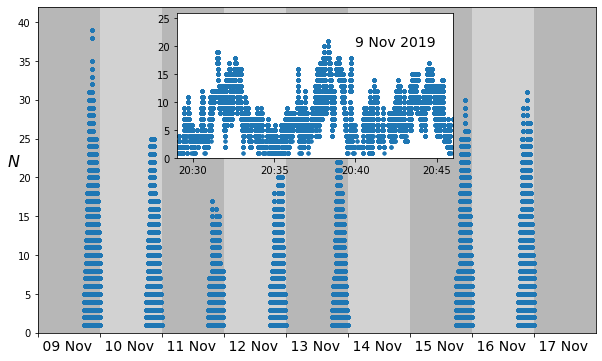

In [7]:
fig, ax = plt.subplots(figsize=(10,6))

##############################################################

ax.plot(df.time.values, df.N_global.values, '.')

##############################################################

ax_ins = inset_axes(ax,
                    width ="50%", # width = 30% of parent_bbox
                    height="45%", # height : 1 inch
                    bbox_to_anchor=(.24, .52, .99, .99),
                    bbox_transform=ax.transAxes, loc=3
                    )

ax_ins.plot(df.time.values, df.N_global.values, '.')
##############################################################
    
x_data = pd.date_range('2019-11-09', periods=10, freq='D') 

ax.set_xticks(x_data[:-1])
ax.set_xticklabels([' 09 Nov', 
                    ' 10 Nov', 
                    ' 11 Nov', 
                    ' 12 Nov', 
                    ' 13 Nov', 
                    ' 14 Nov', 
                    ' 15 Nov', 
                    ' 16 Nov', 
                    ' 17 Nov'], fontsize=14)
ax.set_xlim(x_data[0], x_data[-1])

for tick in ax.xaxis.get_majorticklabels():
    tick.set_horizontalalignment("left")

for i in range(0,len(x_data)-1,2):
    ax.axvspan(x_data[i]  , x_data[i+1], facecolor='0.2', alpha=0.35)
for i in range(1,len(x_data)-1,2):    
    ax.axvspan(x_data[i]  , x_data[i+1], facecolor='0.5', alpha=0.35) 

ax.set_ylabel(r'$N$', size=16, rotation=0)
ax.set_ylim(0, 42)

##############################################################

xmin = np.datetime64('2019-11-09T20:29')
xmax = np.datetime64('2019-11-09T20:46')

x_data_ins = pd.date_range('2019-11-09T20:30', periods=4, freq='5min') 
ax_ins.set_xticks(x_data_ins)
ax_ins.set_xticklabels(['20:30', '20:35', '20:40', '20:45'])

ax_ins.set_xlim(xmin, xmax)
ax_ins.set_ylim(0, 26)

ax_ins.text(x=x_data_ins[2], y=20, s='9 Nov 2019', fontsize=14)

##############################################################    
    
plt.show()

### 6. Restrict the analysis to uni-directional configurations

We here drop from the analysis all trajectories of pedestrians
traveling in the opposite direction with respect to the viewpoint in the sketch at the top of this notebook.
We also drop all trajectories that directly or indirectly interact with them,
i.e. both being present at the same time in at least one frame,
or sharing a frame with a pedestrian who has previously interacted with
a trajectory going in the opposite direction.

In [8]:
# we consider only frames where the flow is unidirectional
df['remove'] = df['direction'] # + any other condition you may want to add

# Remove trajectories with interactions with people traveling in the opposite direction
df['remove'] = df.groupby('time').remove.transform('max')
df           = df.query('remove == 0').copy()

### 7. Local fundamental velocity diagram

In [9]:
pathA_data_local = df.query('path_A == 1').groupby('time').agg({'v_sav': lambda x: np.average(x, weights=x), 'tracked_object' : 'count'}).groupby('tracked_object')
pathB_data_local = df.query('path_B == 1').groupby('time').agg({'v_sav': lambda x: np.average(x, weights=x), 'tracked_object' : 'count'}).groupby('tracked_object')

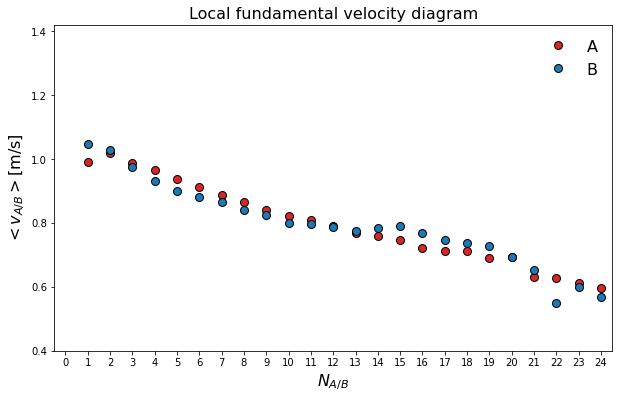

In [10]:
fig, ax = plt.subplots(figsize=(10,6))

for N_val, groubpy in pathA_data_local:
    ax.plot(N_val, np.average(groubpy.v_sav, weights=groubpy.v_sav), 'o', color='C3', ms=8, markeredgecolor='k')

for N_val, groubpy in pathB_data_local:
    ax.plot(N_val, np.average(groubpy.v_sav, weights=groubpy.v_sav), 'o', color='C0', ms=8, markeredgecolor='k')    

ax.set_xlabel('$N_{A/B}  $'     , size=16)
ax.set_ylabel('$<v_{A/B}>$[m/s]', size=16)

ax.plot(-1,-1, 'o', color='C3', markeredgecolor='k', ms=8, label='A')
ax.plot(-1,-1, 'o', color='C0', markeredgecolor='k', ms=8, label='B')

ax.set_xticks(np.arange(30))

ax.set_xlim(-0.5, 24.5)
ax.set_ylim( 0.4, 1.42)

ax.legend(loc='best', frameon=False, prop={'size' : 16})

ax.set_title('Local fundamental velocity diagram', size=16)

plt.show()

### 8. Global fundamental velocity diagram

In [11]:
pathA_data_global      = df.query('path_A == 1').groupby('N_global')
pathB_data_global      = df.query('path_B == 1').groupby('N_global')    

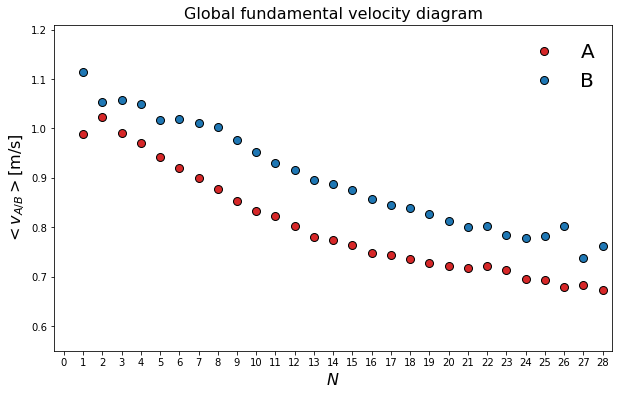

In [12]:
fig, ax = plt.subplots(figsize=(10,6))

for N_val, groubpy in pathA_data_global:
    ax.plot(N_val, np.average(groubpy.v_sav, weights=groubpy.v_sav), 'o', color='C3', ms=8, markeredgecolor='k')

for N_val, groubpy in pathB_data_global:
    ax.plot(N_val, np.average(groubpy.v_sav, weights=groubpy.v_sav), 'o', color='C0', ms=8, markeredgecolor='k')    
    
ax.set_xlabel('$N$'             , size=16)
ax.set_ylabel('$<v_{A/B}>$[m/s]', size=16)

ax.set_xticks(np.arange(29))

ax.plot(-1,-1, 'o', color='C3', markeredgecolor='k', ms=8, label='A')
ax.plot(-1,-1, 'o', color='C0', markeredgecolor='k', ms=8, label='B')

ax.legend(loc='upper right', frameon=False, prop={'size' : 20})

ax.set_xlim(-0.50, 28.50)
ax.set_ylim( 0.55,  1.21)

ax.set_title('Global fundamental velocity diagram', size=16)

plt.show()

### 9. Pedestrian routing choices as function of the global count

In this plot we show the average number of people taking path $A$ ($<N_A>$, red dots) and 
$B$ ($<N_B>$, blue dots) as a function of the global pedestrian count $N$. 
Moreover, the blue colorbars provide a visual representation of the probability distribution $P(N_B | N )$ of number of
people taking path B, conditioned to the global pedestrian count $N$.

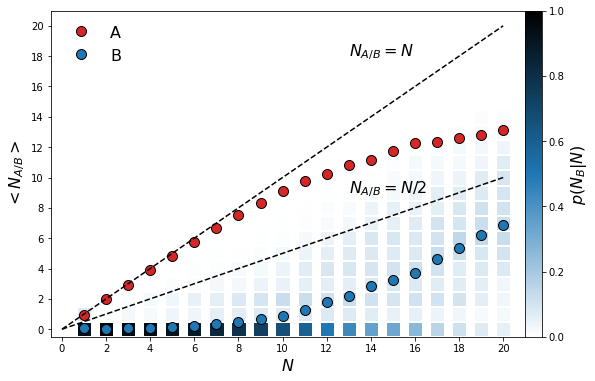

In [13]:
fig, ax = plt.subplots(figsize=(10,6))

cmap1 = mpl.colors.LinearSegmentedColormap.from_list("",['white','C3', 'k'])
cmap2 = mpl.colors.LinearSegmentedColormap.from_list("",['white','C0', 'k'])

Nmax = 21
bins = np.arange(Nmax)

for N in range(1,Nmax):
    
    Nb     = df.query('N_global == @N').N_B
    
    pdf, _ = np.histogram(Nb, bins=bins, density=1)
    pdf    = pdf / np.sum(pdf)

    ax.plot(N, np.average(N-Nb), 'o', ms=10, markeredgecolor='k', color='C3')
    ax.plot(N, np.average(Nb)  , 'o', ms=10, markeredgecolor='k', color='C0')

    cbar = ax.scatter(N*np.ones(Nmax-1), bins[:-1], c=pdf, marker='s', s=150, cmap=cmap2, vmin=0, vmax=1)
    
ax.plot(-1,-1, 'o', ms=10, markeredgecolor='k', color='C3', label='A')
ax.plot(-1,-1, 'o', ms=10, markeredgecolor='k', color='C0', label='B')
    
ax.plot(np.arange(Nmax),     np.arange(Nmax), ls='--', color='k')
ax.plot(np.arange(Nmax), 0.5*np.arange(Nmax), ls='--', color='k')
ax.text(13, 9,r"$N_{A/B} = N/2$", color='k', size=16 )
ax.text(13,18,r"$N_{A/B} = N  $", color='k', size=16 )    

ax.set_xlabel('$N$'        , size=16)
ax.set_ylabel('$<N_{A/B}>$', size=16)

ax.set_xticks(np.arange(0,Nmax+1,2))
ax.set_xlim(-0.5,Nmax)

ax.set_yticks(np.arange(0,Nmax+1,2))
ax.set_ylim(-0.5,Nmax)

cbar = fig.colorbar(cbar, pad=0)
cbar.set_label('$p(N_B | N)$', size=16)

ax.legend(loc='best', frameon=False, prop={'size' : 16})

##########################################

plt.show()